In [244]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
import re
import string
from unidecode import unidecode
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_validate, StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score 
from nltk.corpus import stopwords
from sklearn.manifold import TSNE

In [245]:
df = pd.read_csv('../data/treated_data/data.csv')
df.head()

,id,email_content,email_structure,email_type
0,00001.7848dde101aa985090474a91ec93fcf0,\n\n\n\n\n\n\n\n\n\n\n\n\n\nSave up to 70% on ...,text/html,spam
1,00002.d94f1b97e48ed3b553b3508d116e6a09,1) Fight The Risk of Cancer!\nURL\n\n2) Slim D...,text/plain,spam
2,00003.2ee33bc6eacdb11f38d052c44819ba6c,1) Fight The Risk of Cancer!\nURL\n\n2) Slim D...,text/plain,spam
3,00004.eac8de8d759b7e74154f142194282724,##############################################...,text/plain,spam
4,00005.57696a39d7d84318ce497886896bf90d,I thought you might like these:\n1) Slim Down ...,text/plain,spam


In [246]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   id               3000 non-null   object
 1   email_content    2999 non-null   object
 2   email_structure  3000 non-null   object
 3   email_type       3000 non-null   object
dtypes: object(4)
memory usage: 93.9+ KB


In [247]:
# Checando e dropando NaN 

print(df.isna().sum())
df_tr1 = df.dropna()

id                 0
email_content      1
email_structure    0
email_type         0
dtype: int64


In [248]:
# Checando emails duplicados e removendo emails duplicados

print(f"Duplicated emails: {df_tr1['email_content'].duplicated().sum()}")
df_tr2 = df_tr1[~df_tr1['email_content'].duplicated()]

Duplicated emails: 90


# Pré-processamento

In [249]:
def preprocessing(df):
    email_content = df['email_content'] # Separa a coluna com os emails
    email_content = email_content.apply(lambda x: x.lower()) # Minúsculas
    email_content = email_content.apply(lambda x: re.sub(r'\d+', '', x)) # Remove números
    email_content = email_content.apply(lambda x: re.sub("[.]", " ", x)) # Remove pontos
    email_content = email_content.apply(lambda x: re.sub('[%s]' % re.escape(string.punctuation), '' , x)) # Remove pontuação
    email_content = email_content.str.replace('\n', ' ') # Remove \n
    email_content = email_content.apply(lambda x: re.sub(r'\s{2,}', ' ', x)) # Remove espaços repetidos
    email_content = email_content.str.strip() # Remove trailing spaces
    email_content = email_content.apply(lambda x: unidecode(x, errors="preserve")) # Remove erros de decode
    
    df.loc[:,'email_content'] = email_content
    return df

In [250]:
df_tr3 = preprocessing(df_tr2)

<ipython-input-249-5ce98358a398>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,'email_content'] = email_content


In [251]:
df_tr3.sample(10, random_state=42)

,id,email_content,email_structure,email_type
921,00422.ac4b66f9c3390c3a98d9c8cbe75f403a,hindus got billion gods so losing one is no bi...,text/plain,ham
1276,00777.5abc0824f35b966cf589b15c4f10f2d2,anyone heard of this law before q can i get a ...,text/plain,ham
928,00429.5c83e9a65ee27155654607ee770b8142,someone needs to tell the mayor about this url...,text/plain,ham
400,00401.309e29417819ce39d8599047d50933cc,a great sponsor will not make you money a grea...,text/plain,spam
651,00152.703c271de3d42fb8bf266db6f77a0dda,thanks for the info aj i found weblog at url w...,text/plain,ham
2643,02144.9288d3523cb8cb036f166e3b69c7ce05,url url date t url,text/plain,ham
348,00349.dd7982f40576ff4897c18efc813e38bf,dear free member you were gifted a free member...,text/plain,spam
2211,01712.c20d5899b4b27415389a10cd4f400019,guido on the classifier pickle on sf i downloa...,text/plain,ham
2395,01896.516f258e3f8185d4a0e002a7d806bddf,url url date not supplied stefan sez a federal...,text/plain,ham
531,00032.57e29a75bca42afb412fc68d5051aa20,an apparent quote from dubya from the times se...,text/plain,ham


# Train test split

In [252]:
# Train test split

X = df_tr2['email_content']
y = df_tr2['email_type']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [253]:
# Label encoding

from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()

y_train_tr = label_encoder.fit_transform(y_train)
y_test_tr = label_encoder.transform(y_test)

# EDA

In [254]:
# Verificando proporções dos targets

y_train.value_counts(normalize=True)

ham     0.846154
spam    0.153846
Name: email_type, dtype: float64

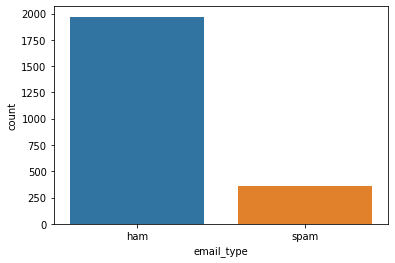

In [255]:
ax = sns.countplot(x=y_train)

In [256]:
# Sentiment analysis

from nltk.sentiment.vader import SentimentIntensityAnalyzer

sentiment_analyzer = SentimentIntensityAnalyzer()

df_tr4 = df_tr3.copy()
df_tr4['negative_sentiment'] = df_tr4['email_content'].apply(lambda x: sentiment_analyzer.polarity_scores(x)['neg'])
df_tr4['neutral_sentiment'] = df_tr4['email_content'].apply(lambda x: sentiment_analyzer.polarity_scores(x)['neu'])
df_tr4['positive_sentiment'] = df_tr4['email_content'].apply(lambda x: sentiment_analyzer.polarity_scores(x)['pos'])

In [284]:
df_tr4.head()

,id,email_content,email_structure,email_type,negative_sentiment,neutral_sentiment,positive_sentiment
0,00001.7848dde101aa985090474a91ec93fcf0,save up to on life insurance why spend more th...,text/html,spam,0.035,0.700,0.265
1,00002.d94f1b97e48ed3b553b3508d116e6a09,fight the risk of cancer url slim down guarant...,text/plain,spam,0.140,0.644,0.216
2,00003.2ee33bc6eacdb11f38d052c44819ba6c,fight the risk of cancer url slim down guarant...,text/plain,spam,0.164,0.582,0.254
3,00004.eac8de8d759b7e74154f142194282724,adult club offers free membership instant acce...,text/plain,spam,0.039,0.768,0.193
4,00005.57696a39d7d84318ce497886896bf90d,i thought you might like these slim down guara...,text/plain,spam,0.165,0.646,0.190


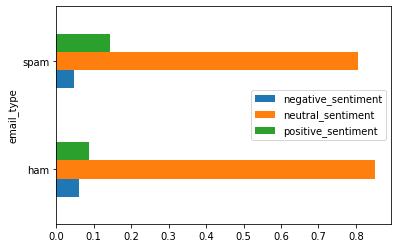

In [257]:
# Plotting mean sentiment distribution

mean_sentiment = df_tr4[['negative_sentiment', 
                         'neutral_sentiment', 
                         'positive_sentiment', 
                         'email_type']].groupby('email_type').mean()

mean_sentiment.plot(kind='barh')
plt.show()

In [258]:
mean_sentiment

,negative_sentiment,neutral_sentiment,positive_sentiment
email_type,,,
ham,0.061228,0.851845,0.086942
spam,0.047228,0.804583,0.143799


## Tipo de email

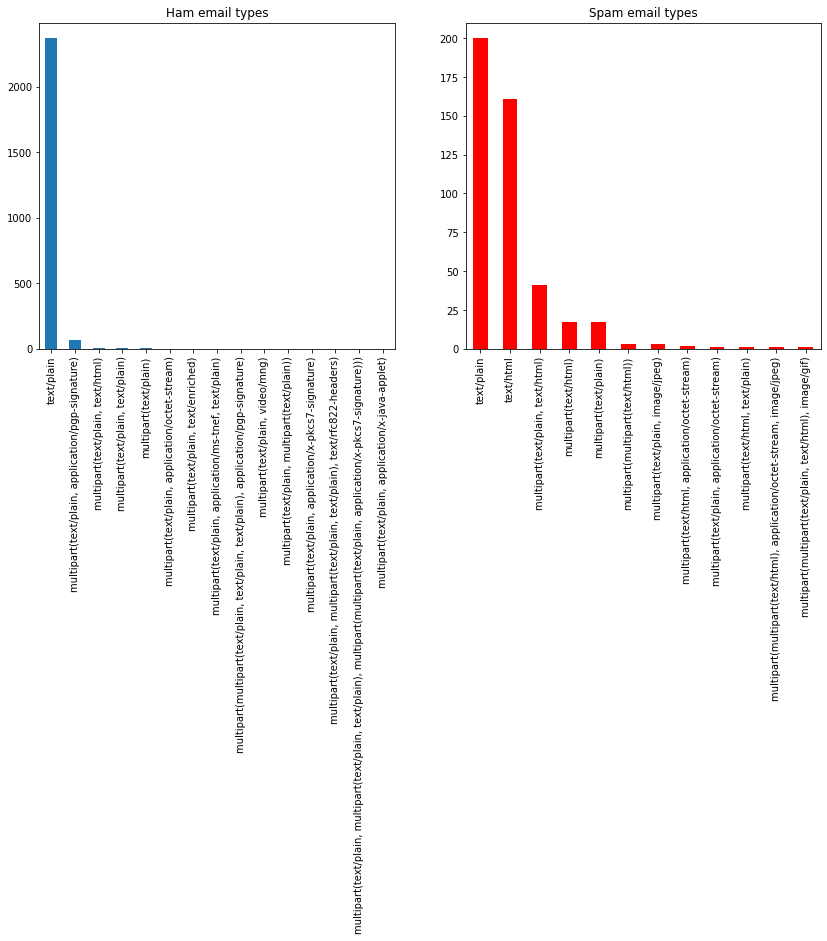

In [282]:
plt.figure(figsize=(14,6))

plt.subplot(1,2,1)
df_tr4.loc[df_tr4['email_type'] == 'ham', 'email_structure'].value_counts().plot(kind='bar')
plt.title('Ham email types')

plt.subplot(1,2,2)
df_tr4.loc[df_tr4['email_type'] == 'spam', 'email_structure'].value_counts().plot(kind='bar', color='r')
plt.title('Spam email types')

plt.show()

## Word cloud

In [58]:
spam_text = ''.join(df_tr3.loc[df_tr3['email_type'] =='spam','email_content'])
ham_text = ''.join(df_tr3.loc[df_tr3['email_type'] =='ham','email_content'])

In [74]:
from wordcloud import WordCloud

wc_ham = WordCloud(width=500, height=500, random_state=42)
wc_spam = WordCloud(width=500, height=500, random_state=42)

wc_ham.generate(ham_text)
wc_spam.generate(spam_text)

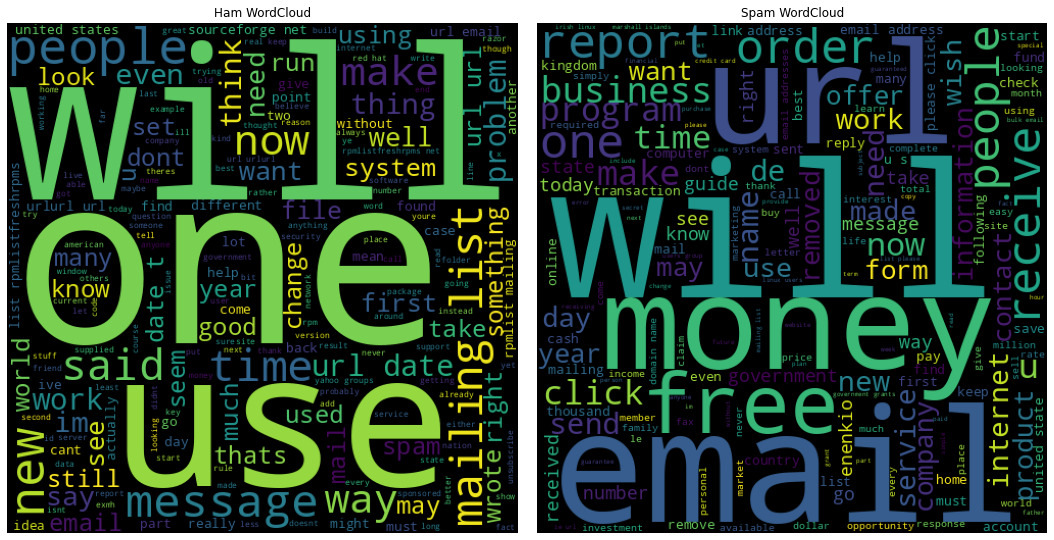

In [77]:
plt.figure(figsize=(15,8))

plt.subplot(1,2,1)
plt.imshow(wc_ham)
plt.title('Ham WordCloud')
plt.axis('off')
plt.tight_layout(pad=2)

plt.subplot(1,2,2)
plt.imshow(wc_spam)
plt.title('Spam WordCloud')
plt.axis('off')
plt.tight_layout(pad=2)

plt.show()

## Verificando a separabilidade dos dados

In [165]:
tsne = TSNE(n_components=2, init="random")

tfidf = TfidfVectorizer(stop_words=stopwords.words('english'))
pipeline = Pipeline([('vectorizer', tfidf), 
                     ('tsne', tsne)])


X_train_reduced = pipeline.fit_transform(X_train)

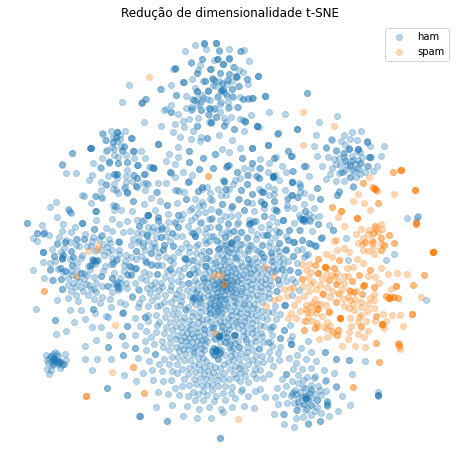

In [176]:
plt.figure(figsize=(8,8))
plt.scatter(X_train_reduced[y_train_tr == 0,0], X_train_reduced[y_train_tr == 0,1], alpha=0.3, label='ham')
plt.scatter(X_train_reduced[y_train_tr == 1,0], X_train_reduced[y_train_tr == 1,1], alpha=0.3, label='spam')
plt.legend()
plt.title('Redução de dimensionalidade t-SNE')
plt.axis('off')
plt.show()

# Treinando modelos

In [118]:
# Pipeline
tfidf = TfidfVectorizer(stop_words=stopwords.words('english'))
forest_clf = RandomForestClassifier(n_estimators=200, class_weight='balanced', random_state=42)

pipeline = Pipeline([('vectorizer', tfidf), 
                     ('model', forest_clf)])

metrics = ['accuracy', 'precision_macro', 'recall_macro']
stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

forest_scores = cross_validate(pipeline, X_train, y_train, scoring=metrics, cv=stratified_kfold)

In [129]:
def report_metrics(scores):
    print(f"Accuracy: {scores['test_accuracy'].mean():.3f} ({scores['test_accuracy'].std():.3f})")
    print(f"Precision: {scores['test_precision_macro'].mean():.3f} ({scores['test_precision_macro'].std():.3f})")
    print(f"Recall: {scores['test_recall_macro'].mean():.3f} ({scores['test_recall_macro'].std():.3f})")
    print(f"Fit time: {scores['fit_time'].mean():.3f} ({scores['fit_time'].std():.3f})")
report_metrics(forest_scores)

Accuracy: 0.976 (0.008)
Precision: 0.980 (0.006)
Recall: 0.925 (0.028)
Fit time: 2.808 (0.173)


In [130]:
# Logistic Regression

from sklearn.linear_model import LogisticRegression

log_clf = LogisticRegression(class_weight='balanced')

pipeline = Pipeline([('vectorizer', tfidf), 
                     ('model', log_clf)])

log_scores = cross_validate(pipeline, X_train, y_train, scoring=metrics, cv=stratified_kfold)
report_metrics(log_scores)

Accuracy: 0.985 (0.007)
Precision: 0.983 (0.010)
Recall: 0.957 (0.016)
Fit time: 0.744 (0.118)


In [131]:
# KNN

from sklearn.neighbors import KNeighborsClassifier

knn_clf = KNeighborsClassifier(n_neighbors=15)

pipeline = Pipeline([('vectorizer', tfidf), 
                     ('model', knn_clf)])

knn_scores = cross_validate(pipeline, X_train, y_train, scoring=metrics, cv=stratified_kfold)
report_metrics(knn_scores)

Accuracy: 0.970 (0.007)
Precision: 0.954 (0.018)
Recall: 0.928 (0.011)
Fit time: 0.299 (0.007)


In [132]:
# SVC

from sklearn.svm import LinearSVC

svc_clf = LinearSVC(class_weight='balanced')

pipeline = Pipeline([('vectorizer', tfidf), 
                     ('model', svc_clf)])

svc_scores = cross_validate(pipeline, X_train, y_train, scoring=metrics, cv=stratified_kfold)
report_metrics(svc_scores)

Accuracy: 0.988 (0.004)
Precision: 0.991 (0.005)
Recall: 0.965 (0.012)
Fit time: 0.348 (0.008)


In [134]:
# LGBM

from lightgbm import LGBMClassifier

lgbm_clf = LGBMClassifier(class_weight='balanced')

pipeline = Pipeline([('vectorizer', tfidf), 
                     ('model', lgbm_clf)])

lgbm_scores = cross_validate(pipeline, X_train, y_train, scoring=metrics, cv=stratified_kfold)
report_metrics(lgbm_scores)

Accuracy: 0.973 (0.005)
Precision: 0.942 (0.016)
Recall: 0.958 (0.010)
Fit time: 1.144 (0.021)


# Deep Learning

In [208]:
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer

from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.wrappers.scikit_learn import KerasClassifier

In [212]:
# Vetorizar

count_vectorizer = CountVectorizer()
X_train_vec = count_vectorizer.fit_transform(X_train)
X_train_vec.sort_indices()

In [216]:
# Criando a rede neural

def make_classifier():
    nn = Sequential()
    nn.add(Dense(units=10, activation='relu', input_dim=X_train_vec.shape[1])) # Input layer
    nn.add(Dropout(0.1)) # Remove aleatoriamente 1% das sinapses
    nn.add(Dense(units=8, activation='relu')) # Hidden layer
    nn.add(Dense(units=1, activation='sigmoid')) # Output layer
    nn.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])
    return nn

model = KerasClassifier(build_fn=make_classifier, epochs=20, batch_size=10, verbose=0)

nn_scores = cross_validate(model, X_train_vec, y_train_tr, scoring=metrics, cv=stratified_kfold)
report_metrics(nn_scores)

<ipython-input-216-59565d3c0fa3>:12: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=make_classifier, epochs=20, batch_size=10, verbose=0)


15/15 [==============================] - 0s 2ms/step
Accuracy: 0.988 (0.006)
Precision: 0.983 (0.010)
Recall: 0.973 (0.015)
Fit time: 17.750 (0.622)


# Avaliação final

In [227]:
# Melhor modelo

from sklearn.svm import SVC

svc_clf = SVC(kernel='linear', class_weight='balanced', probability=True)

pipeline = Pipeline([('vectorizer', tfidf), 
                     ('model', svc_clf)])

pipeline.fit(X_train, y_train_tr)

Pipeline(steps=[('vectorizer',
                 TfidfVectorizer(stop_words=['i', 'me', 'my', 'myself', 'we',
                                             'our', 'ours', 'ourselves', 'you',
                                             "you're", "you've", "you'll",
                                             "you'd", 'your', 'yours',
                                             'yourself', 'yourselves', 'he',
                                             'him', 'his', 'himself', 'she',
                                             "she's", 'her', 'hers', 'herself',
                                             'it', "it's", 'its', 'itself', ...])),
                ('model',
                 SVC(class_weight='balanced', kernel='linear',
                     probability=True))])

In [228]:
# Avaliação de treino

y_train_pred = pipeline.predict(X_train)
print(classification_report(y_train_tr, y_train_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1969
           1       1.00      0.99      1.00       358

    accuracy                           1.00      2327
   macro avg       1.00      1.00      1.00      2327
weighted avg       1.00      1.00      1.00      2327



In [229]:
# Avaliação de teste

y_test_pred = pipeline.predict(X_test)
print(classification_report(y_test_tr, y_test_pred))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99       492
           1       1.00      0.91      0.95        90

    accuracy                           0.99       582
   macro avg       0.99      0.96      0.97       582
weighted avg       0.99      0.99      0.99       582



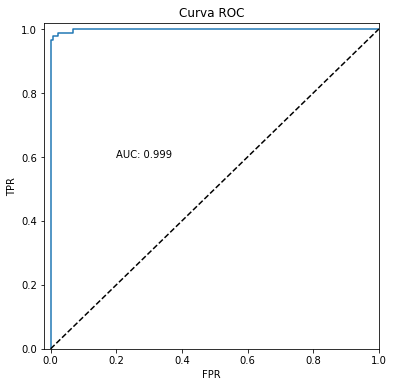

In [243]:
from sklearn.metrics import roc_curve, roc_auc_score

y_test_proba = pipeline.predict_proba(X_test)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test_tr, y_test_proba)
auc = np.round(roc_auc_score(y_test, y_test_proba),3)

plt.figure(figsize=(6,6))
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([-0.02, 1.00])
plt.ylim([0.0, 1.02])
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('Curva ROC')
plt.annotate(text=f'AUC: {auc}', xy=(0.2, 0.6))
plt.show()

In [ ]:
# Add email type
# Balanceamento (undersampling)
# Lemmatizing / steeming